# EDA of initial training data

NumExpr defaulting to 4 threads.


  0%|                                                                                          | 0/658 [00:00<…


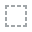
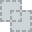
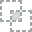
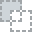
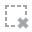
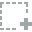
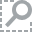
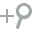
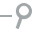
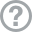
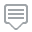
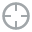
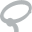
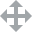
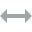
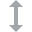
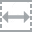
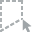
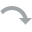
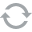
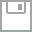
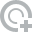
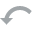
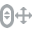
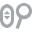
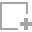
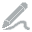
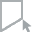
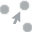
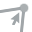
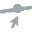

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataprep.eda import plot

trawlers_df = pd.read_csv('../data/trollers.csv')
plot(trawlers_df)

In [2]:
trawlers_df = trawlers_df[trawlers_df['is_fishing'] != -1]
trawlers_df['is_fishing'] = [0 if x < 0.3 else 1 for x in trawlers_df['is_fishing']]
trawlers_df = trawlers_df[['is_fishing', 'lat', 'lon', 'course', 'speed', 'timestamp', 'distance_from_shore', 'distance_from_port', 'mmsi', 'source']]
trawlers_df = trawlers_df.dropna()

## Section 1 - Finding feature importance

From Dataprep, we can see that there are 9 features with 1 label. The label is the is_fishing column. From the documentation, -1 is when the expert cannot determine the activity, and from 0 to 1 is when the expert ranks if there's any indication of fishing activity. This section determines feature importance using random forest and selecting the top 8 important features.

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

from collections import Counter

train, test = train_test_split(trawlers_df, test_size=0.2, random_state=42)
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
feature_names = list(X_train)


In [4]:
le = LabelEncoder()
X_train['source'] = le.fit_transform(X_train['source'].values)

scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)

rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
print(importances)

important_dict = {}
for name, importance in zip(feature_names, importances):
    important_dict[name] = importance
sort_important_dict = dict(Counter(important_dict).most_common(8))

X_train = X_train[sort_important_dict.keys()]
X_test = X_test[sort_important_dict.keys()]
print(X_train.columns)

[0.13048762 0.10327927 0.04441875 0.16363239 0.26307304 0.06598429
 0.18528657 0.04383807 0.        ]
Index(['timestamp', 'distance_from_port', 'speed', 'lat', 'lon',
       'distance_from_shore', 'course', 'mmsi'],
      dtype='object')


<BarContainer object of 8 artists>

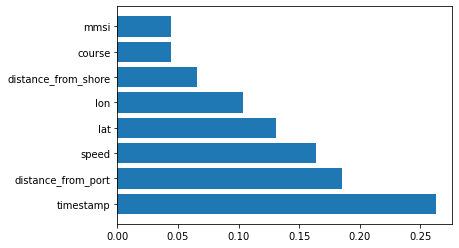

In [5]:
plt.barh(*zip(*sort_important_dict.items()))

## Section 2 - Evaluating feature importance

This section uses gradient boosted tree to retrain the features after eliminating the unique feature (mmsi) and unused feature (source). The training results are decent from the f1 score and roc curve. However, upon further evaluation using Shap value and the blackbox model to explain the features, we noticed that there is a discrepancy in the features between what we expect and what is presented. For example, the timestamp and latitude are important from applying explainable machine learning, but these should not be the main features to predict fishing activities (fishing vessels can operate at different latitudes, during a different time, and with different timezones).

In [6]:
try:
    del X_train['mmsi']
    del X_test['mmsi']
    del X_train['source']
    del X_test['source']
except Exception:
    print('nothing to delete')

gbt = GradientBoostingClassifier(n_estimators=100)
gbt.fit(X_train, y_train)
# scores = cross_val_score(estimator=gbt,X=X_test, y=y_test, cv=3, scoring="roc_auc")

scaler = MinMaxScaler()
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns)

pred_prob = gbt.predict(X_test)
f1_score(y_test, pred_prob)

nothing to delete


0.9239864864864865

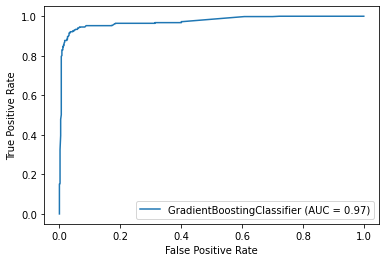

In [7]:
plot_roc_curve(estimator=gbt,X=X_test, y=y_test)

### Shap values

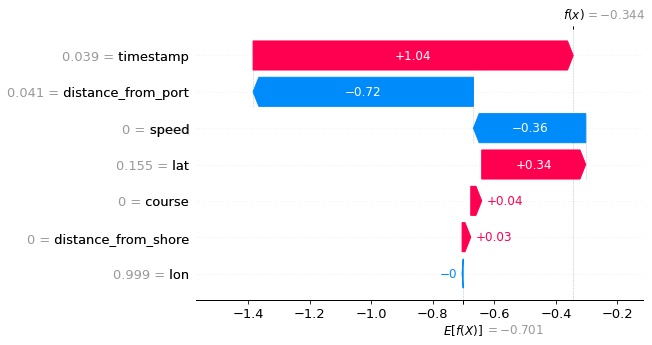

In [8]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(gbt)
shap_values = explainer.shap_values(X_test)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0,:], X_test.iloc[0,:])

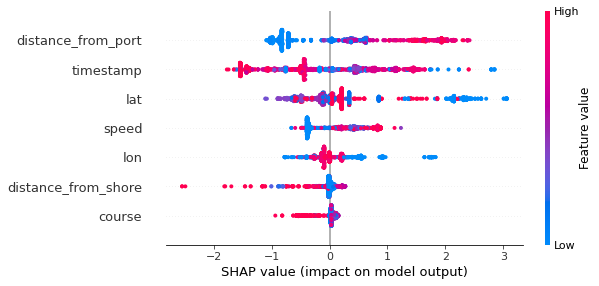

In [9]:
shap.summary_plot(shap_values, X_test)

### Global surrogate - logistic regression

In [10]:
# adapted from assignment for black box

def explain_logistic_regression(lr, feature_names):
    plt.bar(feature_names, lr.coef_[0])
    plt.xticks(rotation='vertical')
    plt.ylabel('coefficient value')
    
def global_surrogate(model, X, model_name):
    prediction = model.predict(X)
    lr_temp = LogisticRegression(solver='liblinear').fit(X, prediction)
    explain_logistic_regression(lr_temp, X_test.columns)
    plt.title(model_name)
    plt.show()
    plt.close()

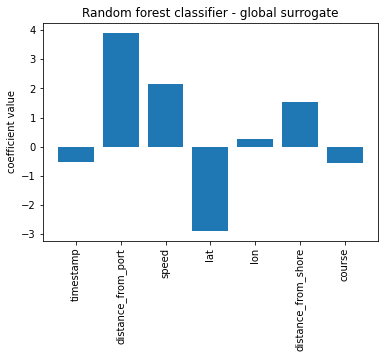

In [11]:
global_surrogate(gbt, X_test, 'Random forest classifier - global surrogate')

## Section 3

From the reasons below regarding the features, we decided to narrow down our dataset to 4 features to see which features we should expand on. For example, we noticed that speed isn't much of a relevant feature, so we can expand the speed feature to rolling mean, expanding mean, or difference in speed to see if we can find more correlation.

1. mmsi: mmsi should not affect the model since it is a unique identifier for each vessel
2. lon/lat: longitude and latitude will be good display parameters but should not rank as the almost deciding factor for model training (eg. training data might contain only Africa fishing ground, but future prediction data might be from Canada)
3. time: time is measured in Unix time, which would be a terrible feature to train model since the day in Canada is the night in china
4. source is somewhat irrelevant to some type of vessels


In [12]:
trawlers_df = trawlers_df[['is_fishing', 'course', 'speed', 'distance_from_shore', 'distance_from_port']]
train, test = train_test_split(trawlers_df, test_size=0.2, random_state=42)
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
feature_names = list(X_train)
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_train

course     speed  distance_from_shore  distance_from_port
0     0.922735  0.143939             0.577675            0.486752
1     0.000000  0.000000             0.010609            0.012154
2     0.000000  0.000000             0.010609            0.012154
3     0.465536  0.613636             0.650873            0.579627
4     0.056698  0.234848             0.509339            0.684282
...        ...       ...                  ...                 ...
6271  0.469427  0.583333             0.706669            0.630233
6272  0.863813  0.113636             0.685980            0.683040
6273  0.714286  0.363636             0.000000            0.085939
6274  0.000000  0.000000             0.000000            0.050111
6275  0.546971  0.000000             0.000000            0.050111

[6276 rows x 4 columns]

In [13]:
gbt.fit(X_train, y_train)
importances = gbt.feature_importances_
f1_score(y_test, pred_prob)

0.9239864864864865

Text(0, 0.5, 'feature importance')

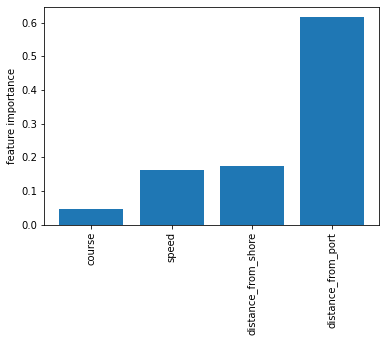

In [14]:
plt.bar(X_train.columns, importances)
plt.xticks(rotation='vertical')
plt.ylabel('feature importance')

### shap and roc score using new features

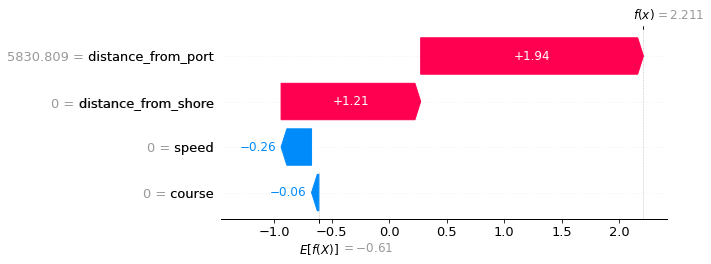

In [15]:
explainer = shap.TreeExplainer(gbt)
shap_values = explainer.shap_values(X_test)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0,:], X_test.iloc[0,:])

## Summary

From this EDA, we learn about the feature composition in the training data. Most importantly, we understand which features are unique, which features are important, and which features we should expand on.